In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.4s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Null gene set

In [7]:
np.random.seed(0)
gs_size_list = [20, 100, 500]
n_rep=10
dic_nullset= {}

md.compute_stats(data_facs_ct)
df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.var['mean'].values
df_gene['std'] = np.sqrt(data_facs_ct.var['var'].values)
df_gene['cv'] = df_gene['std'].values/df_gene['mean'].values
df_gene['var'] = data_facs_ct.var['var'].values
df_gene['var_tech'] = data_facs_ct.var['var_tech'].values
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(data_facs_ct.shape[1])[:n_gene]
        gs_name = 'size%d_rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(data_facs_ct.var_names[ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        # Select lowly- and highly- expressed random genes 
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'size%d_rep%d_lowexp'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[:5000][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'size%d_rep%d_highexp'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[-5000:][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# size20_rep0          n_gene=20  mean=8.21e-02 std=1.12e-01
# size20_rep1          n_gene=20  mean=1.18e-01 std=2.10e-01
# size20_rep2          n_gene=20  mean=1.07e-01 std=1.45e-01
# size20_rep3          n_gene=20  mean=1.16e-01 std=1.49e-01
# size20_rep4          n_gene=20  mean=5.27e-02 std=6.10e-02
# size20_rep5          n_gene=20  mean=9.67e-02 std=1.93e-01
# size20_rep6          n_gene=20  mean=1.51e-01 std=3.18e-01
# size20_rep7          n_gene=20  mean=7.55e-02 std=9.46e-02
# size20_rep8          n_gene=20  mean=5.16e-02 std=8.07e-02
# size20_rep9          n_gene=20  mean=5.88e-02 std=8.39e-02
# size100_rep0         n_gene=100 mean=9.58e-02 std=2.21e-01
# size100_rep1         n_gene=100 mean=9.76e-02 std=2.15e-01
# size100_rep2         n_gene=100 mean=1.09e-01 std=2.26e-01
# size100_rep3         n_gene=100 mean=8.32e-02 std=2.07e-01
# size100_rep4         n_gene=100 mean=1.15e-01 std=2.37e-01
# size100_rep5         n_gene=100 mean=1.34e-01 std=2.90e-01
# size100_rep6         n

### Test TRS

In [8]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [17]:
# Obtain TRS: This takes a lot of time.
# null_trait_list = ['size500_rep%d_highexp'%x for x in range(10)]
# null_trait_list = ['size500_rep%d_highexp'%x for x in [8]]
# null_trait_list = ['size20_rep%d_lowexp'%x for x in [0]]
# null_trait_list = ['size20_rep%d_lowexp'%x for x in range(10)]
# null_trait_list = ['size500_rep%d'%x for x in [8]]
# null_trait_list = ['size500_rep%d'%x for x in range(10)]
null_trait_list=['size500_rep0_lowexp', 'size500_rep0_highexp', 'size500_rep0']
start_time = time.time()
dic_trs={}
dic_raw_trs={}
dic_trs_z={}
for trait in null_trait_list:
    
    gene_list=list(dic_nullset[trait])
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi', 
                  n_ctrl=1, n_genebin=200,
                  return_list=['trs', 'trs_ctrl0', 'trs_ep', 'trs_tp', 'trs_z', 'trs_ctrl0_z'], verbose=False)
#     dic_trs[trait] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_raw_trs[trait] = data_facs_ct.obs['trs'].values.copy()
    dic_trs_z[trait] = data_facs_ct.obs['trs_z'].values.copy()
    print('# %s time=%0.1fs'%(trait,time.time()-start_time))

# size500_rep0_lowexp time=1.6s
# size500_rep0_highexp time=4.0s
# size500_rep0 time=6.0s


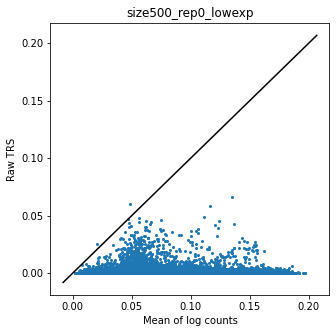

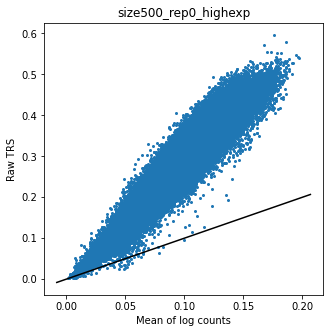

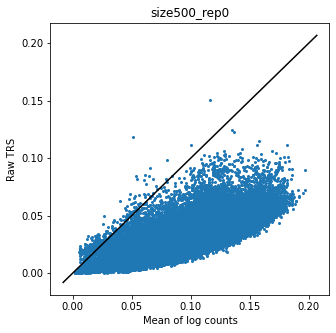

In [16]:
# Distribution plot
for trait in null_trait_list:
    fig = plt.figure(figsize=[5,5])
    # original TRS
    plt.scatter(data_facs_ct.obs['mean'].values, dic_raw_trs[trait], 
                c='C0', s=4, alpha=1, cmap='Reds')
    # plt.ylim([-0.2,0.2])
    xmin,xmax = plt.xlim()
    plt.plot([xmin,xmax],[xmin,xmax],color='k',zorder=10)
    plt.xlabel('Mean of log counts')
    plt.ylabel('Raw TRS')
    plt.title(trait)
    plt.show()

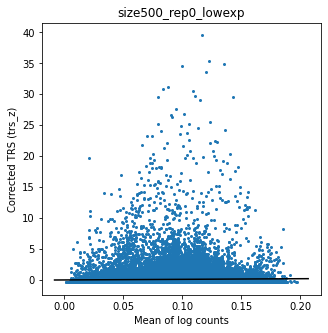

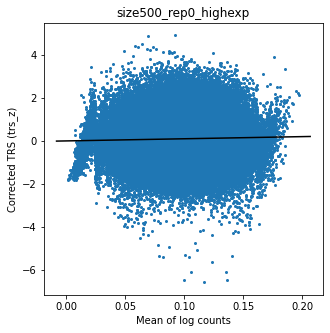

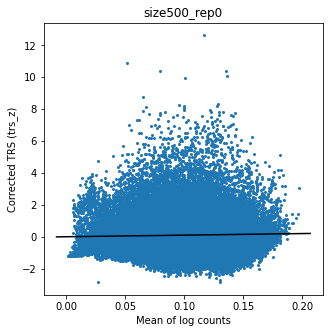

In [19]:
# Distribution plot
for trait in null_trait_list:
    fig = plt.figure(figsize=[5,5])
    # original TRS
    plt.scatter(data_facs_ct.obs['mean'].values, dic_trs_z[trait], 
                c='C0', s=4, alpha=1, cmap='Reds')
    # plt.ylim([-0.2,0.2])
    xmin,xmax = plt.xlim()
    plt.plot([xmin,xmax],[xmin,xmax],color='k',zorder=10)
    plt.xlabel('Mean of log counts')
    plt.ylabel('Corrected TRS (trs_z)')
    plt.title(trait)
    plt.show()

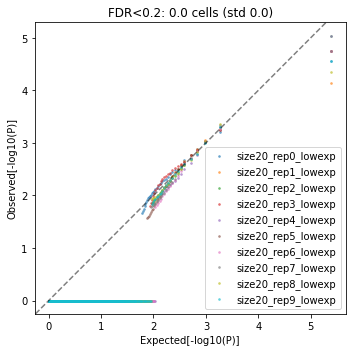

In [126]:
# QQ-plot (bc)
normal_x = np.random.rand(100000)
normal_x = -np.log10(normal_x)
plt.figure(figsize=[5,5])
v_nrej = []
for i_trait,trait in enumerate(dic_trs.keys()):
    v_p = dic_trs[trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    v_nlogp = -np.log10(v_p)
    util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5, color='C%d'%i_trait, label=trait)
    v_nrej.append((v_fdr<0.2).sum())
plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
v_nrej = np.array(v_nrej)
plt.title('FDR<0.2: %0.1f cells (std %0.1f)'%(v_nrej.mean(),v_nrej.std()))
plt.ylabel('Observed[-log10(P)]')
plt.xlabel('Expected[-log10(P)]')
plt.legend()
plt.tight_layout()
plt.show()

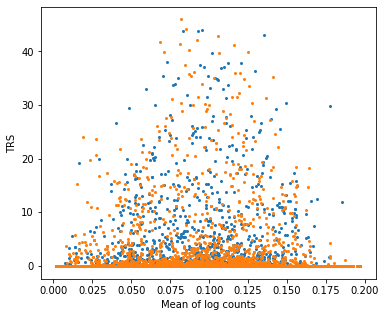

In [124]:
# Distribution plot
fig = plt.figure(figsize=[6,5])
# original TRS
plt.scatter(data_facs_ct.obs['mean'].values, data_facs_ct.obs['trs_z'].values, 
            c='C0', s=4, alpha=1, cmap='Reds')
plt.scatter(data_facs_ct.obs['mean'].values, data_facs_ct.obs['trs_ctrl0_z'].values, 
            c='C1', s=4, alpha=1, cmap='Reds')
# plt.ylim([-0.2,0.2])
plt.xlabel('Mean of log counts')
plt.ylabel('TRS')
plt.show()

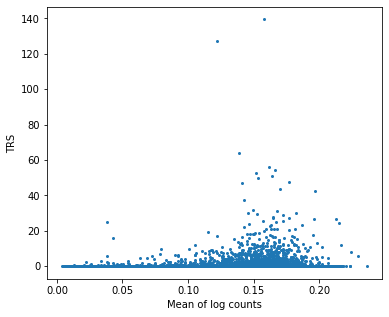

In [111]:
# Distribution plot
fig = plt.figure(figsize=[6,5])
# original TRS
plt.scatter(data_facs_ct.obs['var'].values, data_facs_ct.obs['trs_z'].values, 
            c='C0', s=4, alpha=1, cmap='Reds')
# plt.ylim([-0.2,0.2])
plt.xlabel('Mean of log counts')
plt.ylabel('TRS')
plt.show()

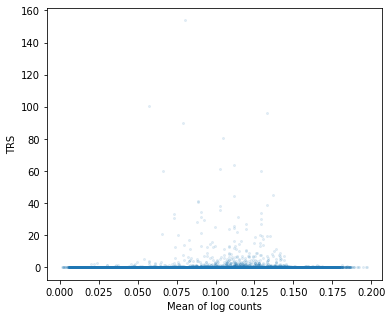

In [81]:
# Distribution plot
fig = plt.figure(figsize=[6,5])
# original TRS
plt.scatter(data_facs_ct.obs['mean'].values, data_facs_ct.obs['trs_z'].values, 
            c='C0', s=4, alpha=0.1, cmap='Reds')
plt.xlabel('Mean of log counts')
plt.ylabel('TRS')
plt.show()

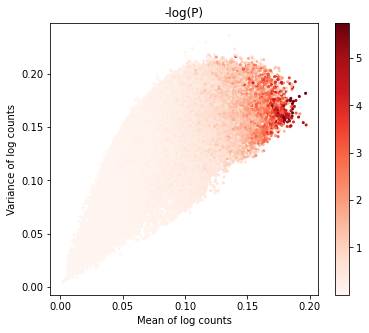

In [60]:
# Distribution plot
fig = plt.figure(figsize=[6,5])
# original TRS
plt.scatter(data_facs_ct.obs['mean'].values, data_facs_ct.obs['var'].values, 
            c=-np.log10(dic_trs[trait]), s=4, cmap='Reds')
plt.xlabel('Mean of log counts')
plt.ylabel('Variance of log counts')
plt.colorbar()
plt.title('-log(P)')
plt.show()

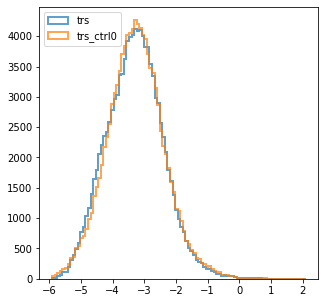

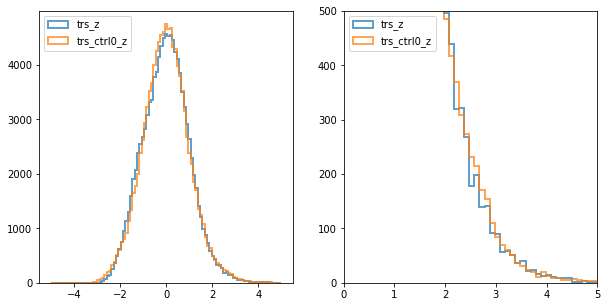

In [57]:
# Distribution plot
bins_ = np.linspace(data_facs_ct.obs['trs'].values.min(),data_facs_ct.obs['trs'].values.max(),100)
fig = plt.figure(figsize=[5,5])
# original TRS
plt.hist(data_facs_ct.obs['trs'].values, histtype='step', bins=bins_, alpha=0.7, label='trs', linewidth=2)
plt.hist(data_facs_ct.obs['trs_ctrl0'].values, histtype='step', bins=bins_, alpha=0.7, label='trs_ctrl0', linewidth=2)
plt.legend(loc='upper left')
plt.show()

# Distribution plot
bins_ = np.linspace(-5,5,100)
fig = plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.hist(data_facs_ct.obs['trs_z'].values, histtype='step', bins=bins_, alpha=0.7, label='trs_z', linewidth=2)
plt.hist(data_facs_ct.obs['trs_ctrl0_z'].values, histtype='step', bins=bins_, alpha=0.7, label='trs_ctrl0_z', linewidth=2)
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.hist(data_facs_ct.obs['trs_z'].values, histtype='step', bins=bins_, alpha=0.7, label='trs_z', linewidth=2)
plt.hist(data_facs_ct.obs['trs_ctrl0_z'].values, histtype='step', bins=bins_, alpha=0.7, label='trs_ctrl0_z', linewidth=2)
plt.ylim([0,500])
plt.xlim([0,5])
plt.legend(loc='upper left')
plt.show()

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df_gene.loc[dic_nullset[null_trait_list[0]]])

                   mean       std        cv       var  var_tech
index                                                          
Nhp2l1         0.530607  0.673792  1.269850  0.453996  0.914681
Mrpl49         0.169190  0.450870  2.664877  0.203283  0.276579
Sox18          0.167228  0.626976  3.749231  0.393099  0.183385
Tmed5          0.431924  0.647959  1.500168  0.419850  0.722012
Rpl13          2.160610  1.035711  0.479360  1.072697  2.399812
Pnn            0.201940  0.424239  2.100814  0.179979  0.284453
Arpc5          1.019105  0.933175  0.915681  0.870815  2.230236
Eif5a          1.681237  1.110360  0.660442  1.232899  2.627838
Hnrnpr         0.324486  0.570194  1.757222  0.325121  0.675841
Gpr18          0.143914  0.563403  3.914861  0.317423  0.155419
Sirpa          0.337622  0.755018  2.236284  0.570053  0.514058
Acsl5          0.285870  0.563381  1.970759  0.317399  0.536966
Ubxn6          0.248429  0.528161  2.126008  0.278955  0.370160
Sesn1          0.190576  0.473963  2.487

### Test score_cell methods

In [8]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

# Known trait-celltype association 
df_annot_assoc = pd.read_excel(DATA_PATH+'/trait_cell_assoc.xlsx')
df_annot_assoc.index = df_annot_assoc['Disease']
df_annot_assoc  = df_annot_assoc.fillna('')

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

# facs data: n_tissue=23 n_tissue_celltype=207


In [9]:
dic_geneset = {}
for trait in trait_list: 
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    dic_geneset[trait] = gene_list.copy()
    print('# %-40s n_gene=%d'%(trait, len(gene_list)))

# PASS_MDD_Wray2018                        n_gene=128
# PASS_ADHD_Demontis2018                   n_gene=236
# PASS_SCZvsBD_Ruderfer2018                n_gene=271
# PASS_Coronary_Artery_Disease             n_gene=165
# PASS_CardioembolicStroke_Malik2018       n_gene=54
# PASS_LDL                                 n_gene=465
# PASS_Rheumatoid_Arthritis                n_gene=287
# PASS_IBD_deLange2017                     n_gene=1731
# PASS_Type_1_Diabetes                     n_gene=340


In [10]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
    gene_list = list(dic_geneset[trait])
    
    for n_nullset_ in [1,5,10]:
        for n_genebin_ in [100,200,500]:
    
            # Empirical p, random_mean_match geneset
            md.score_cell(data_facs_ct, gene_list, suffix='', trs_opt='mean', nullset_opt='random_mean_match',
                          n_nullset=n_nullset_, n_genebin=n_genebin_, flag_correct_background=True,
                          return_list=['trs_ep'], verbose=False)
            config_name = 'ep_meanmatch_nset%d_nbin%d'%(n_nullset_,n_genebin_)
            dic_trs['%s.%s'%(config_name,trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    
    ################################################################################################
    ################################# Some clearly inferior choices ################################
    ################################################################################################
    
    # Empirical p, random_mean_match geneset, no background correction
    md.score_cell(data_facs_ct, gene_list, suffix='', trs_opt='mean', nullset_opt='random_mean_match',
                  n_nullset=1, n_genebin=100, flag_correct_background=False, return_list=['trs_ep'], verbose=False)
    dic_trs['ep_meanmatch_nbc.%s'%trait] = data_facs_ct.obs['trs_ep'].values.copy()
    
    # Empirical p, random geneset 
    md.score_cell(data_facs_ct, gene_list, suffix='', trs_opt='mean', nullset_opt='random',
                  n_nullset=1, n_genebin=100, flag_correct_background=True, return_list=['trs_ep'], verbose=False)
    dic_trs['ep_random.%s'%trait] = data_facs_ct.obs['trs_ep'].values.copy()
    
    # Theoretical p 
    md.score_cell(data_facs_ct, gene_list, suffix='', trs_opt='mean', nullset_opt=None,
                  n_nullset=1, n_genebin=100, flag_correct_background=True, return_list=['trs_tp'], verbose=False)
    dic_trs['tp.%s'%trait] = data_facs_ct.obs['trs_tp'].values.copy()
    
    print('#%-30s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_MDD_Wray2018              time=166.8s
#PASS_ADHD_Demontis2018         time=340.0s
#PASS_SCZvsBD_Ruderfer2018      time=515.2s
#PASS_Coronary_Artery_Disease   time=686.2s
#PASS_CardioembolicStroke_Malik2018 time=848.0s
#PASS_LDL                       time=1023.1s
#PASS_Rheumatoid_Arthritis      time=1195.8s
#PASS_IBD_deLange2017           time=1406.6s
#PASS_Type_1_Diabetes           time=1578.8s


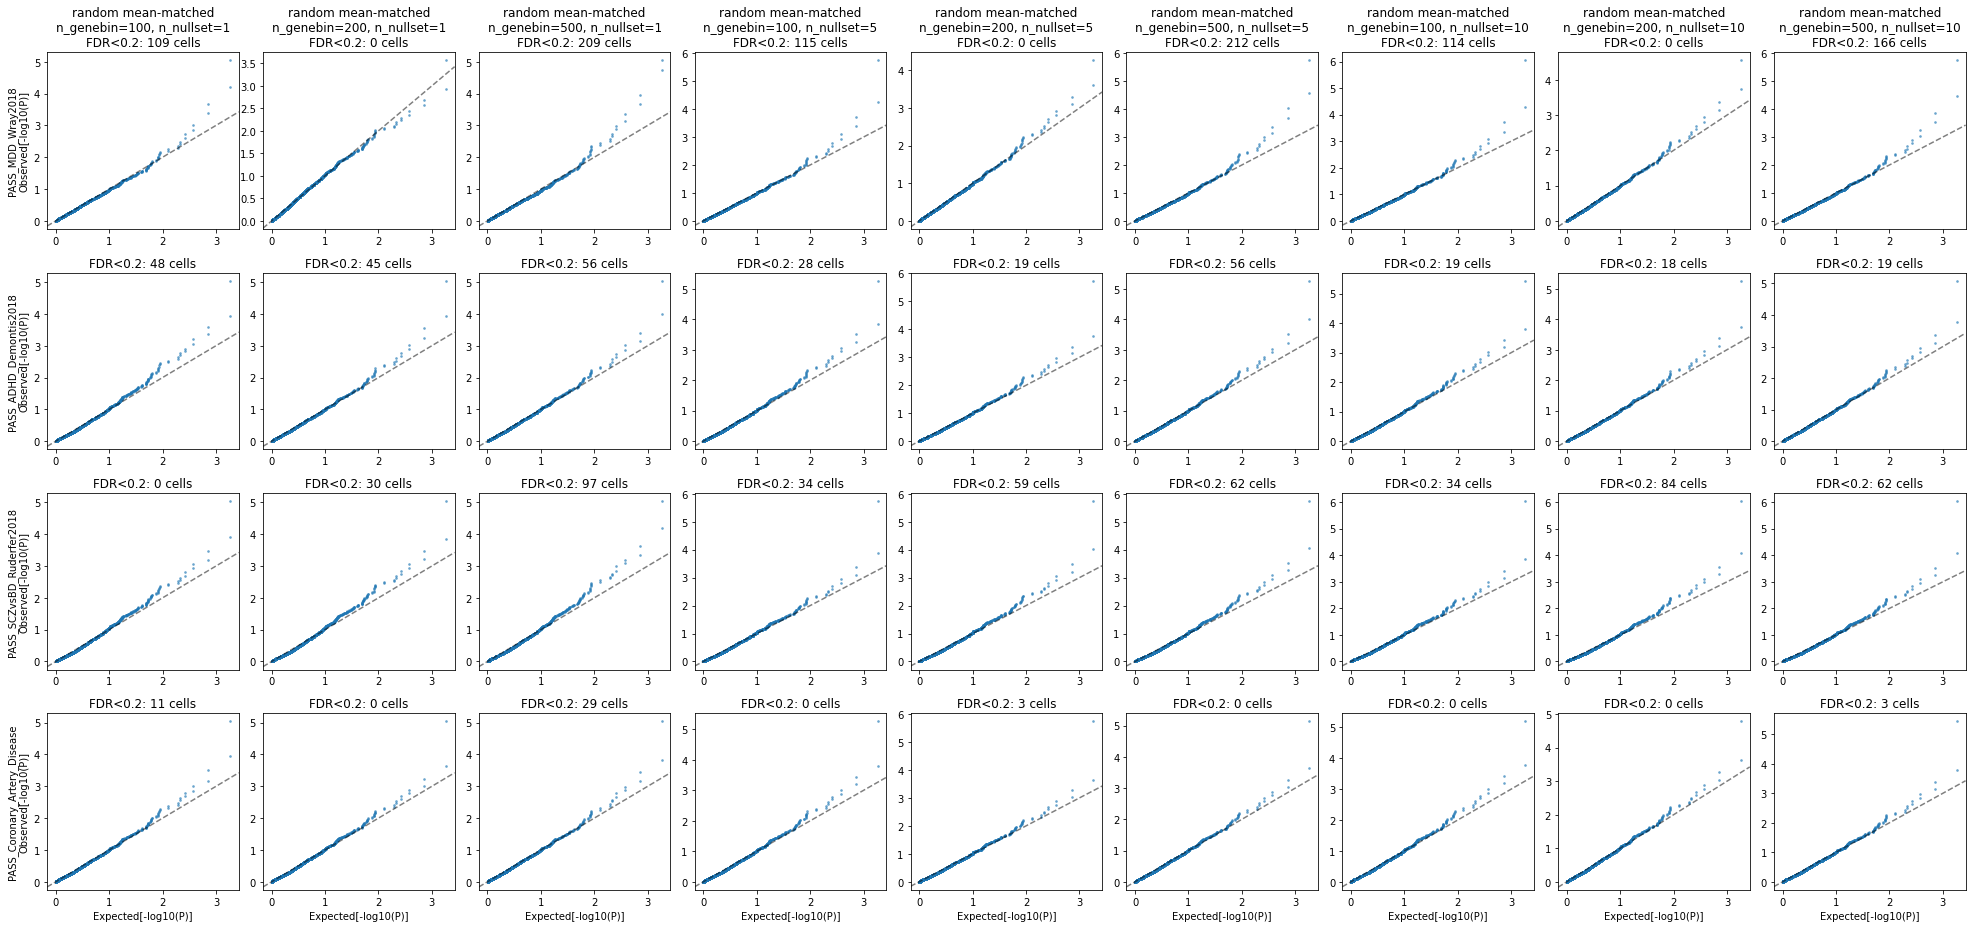

In [11]:
# QQ-plot 
plot_config_list = ['ep_meanmatch_nset1_nbin100', 
                    'ep_meanmatch_nset1_nbin200',
                    'ep_meanmatch_nset1_nbin500',
                    'ep_meanmatch_nset5_nbin100', 
                    'ep_meanmatch_nset5_nbin200',
                    'ep_meanmatch_nset5_nbin500',
                    'ep_meanmatch_nset10_nbin100', 
                    'ep_meanmatch_nset10_nbin200',
                    'ep_meanmatch_nset10_nbin500']
plot_trait_list = trait_list[:4]

normal_x = np.random.rand(1000)
normal_x = -np.log10(normal_x)
    
plt.figure(figsize=[5+2.5*len(plot_config_list), 3+2.5*len(plot_trait_list)])

for i_trait,trait in enumerate(plot_trait_list):    
    for i_config,config in enumerate(plot_config_list):
        
        v_p = dic_trs['%s.%s'%(config,trait)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(len(plot_trait_list), len(plot_config_list),i_trait*len(plot_config_list)+i_config+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        if i_trait==0:
            plt.title('%s\nFDR<0.2: %d cells'%(DIC_CONFIG_NAME[config],(v_fdr<0.2).sum()))
        else:
            plt.title('FDR<0.2: %d cells'%((v_fdr<0.2).sum()))
            
        if i_config==0:
            plt.ylabel('%s\nObserved[-log10(P)]'%trait)
            
        if i_trait==len(plot_trait_list)-1:
            plt.xlabel('Expected[-log10(P)]')
        
plt.tight_layout()
plt.show()

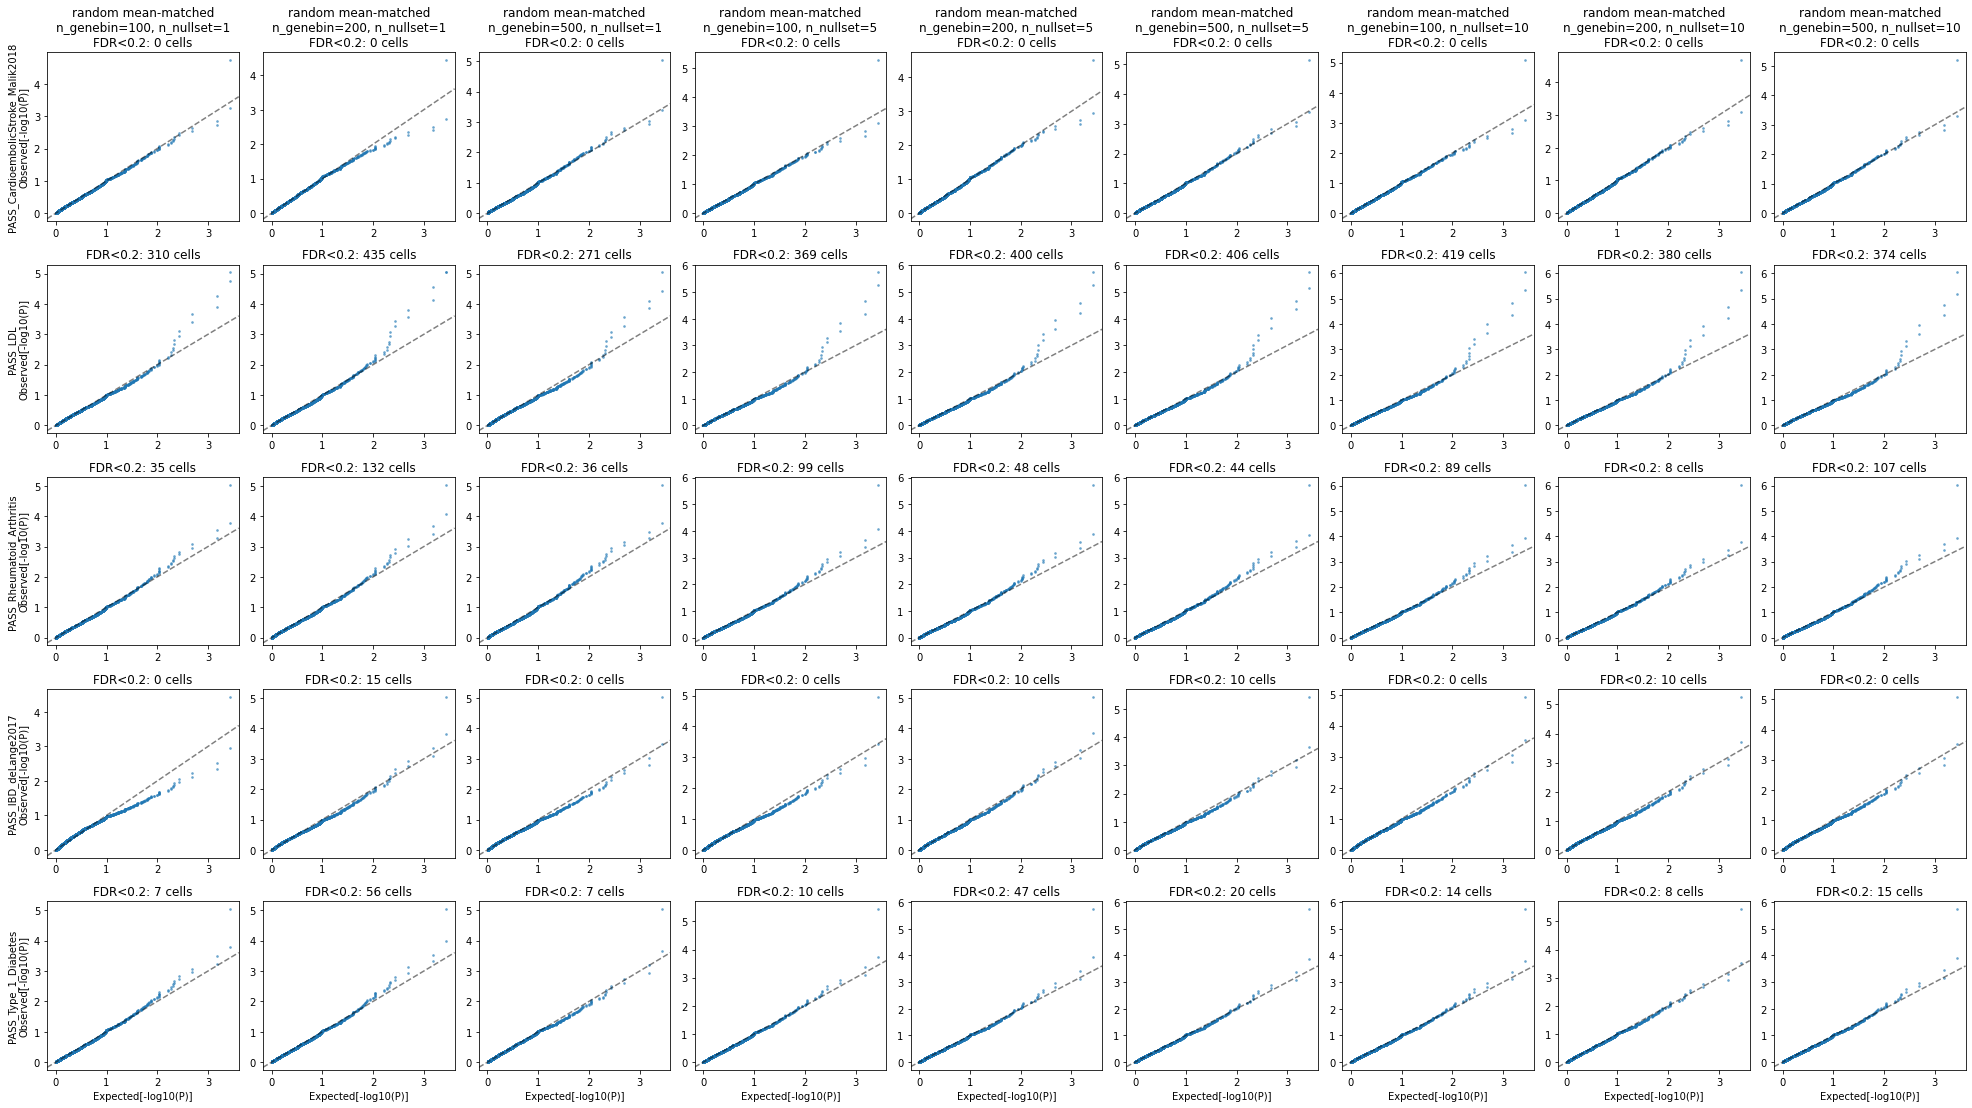

In [12]:
# QQ-plot 
plot_config_list = ['ep_meanmatch_nset1_nbin100', 
                    'ep_meanmatch_nset1_nbin200',
                    'ep_meanmatch_nset1_nbin500',
                    'ep_meanmatch_nset5_nbin100', 
                    'ep_meanmatch_nset5_nbin200',
                    'ep_meanmatch_nset5_nbin500',
                    'ep_meanmatch_nset10_nbin100', 
                    'ep_meanmatch_nset10_nbin200',
                    'ep_meanmatch_nset10_nbin500']
plot_trait_list = trait_list[4:]

normal_x = np.random.rand(1000)
normal_x = -np.log10(normal_x)
    
plt.figure(figsize=[5+2.5*len(plot_config_list), 3+2.5*len(plot_trait_list)])

for i_trait,trait in enumerate(plot_trait_list):    
    for i_config,config in enumerate(plot_config_list):
        
        v_p = dic_trs['%s.%s'%(config,trait)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(len(plot_trait_list), len(plot_config_list),i_trait*len(plot_config_list)+i_config+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        if i_trait==0:
            plt.title('%s\nFDR<0.2: %d cells'%(DIC_CONFIG_NAME[config],(v_fdr<0.2).sum()))
        else:
            plt.title('FDR<0.2: %d cells'%((v_fdr<0.2).sum()))
            
        if i_config==0:
            plt.ylabel('%s\nObserved[-log10(P)]'%trait)
            
        if i_trait==len(plot_trait_list)-1:
            plt.xlabel('Expected[-log10(P)]')
        
plt.tight_layout()
plt.show()

In [13]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['ep_meanmatch_nset5_nbin200.%s'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

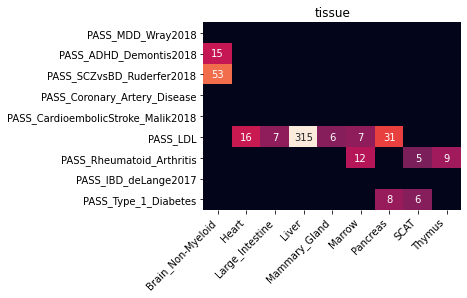

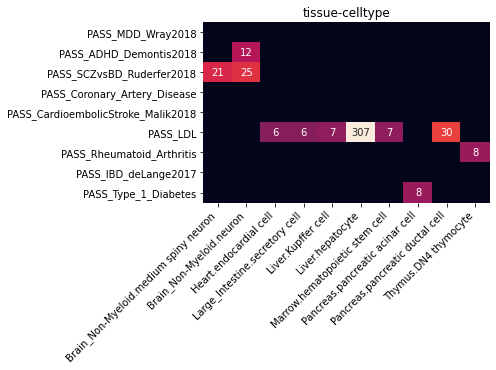

In [14]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

In [72]:
# # Specificity
# df_spec_tissue = pd.DataFrame(index=CONFIG_LIST, columns=trait_list, data=0)
# df_spec_tc = pd.DataFrame(index=CONFIG_LIST, columns=trait_list, data=0)
# df_obs = data_facs_ct.obs.copy()

# for trait in trait_list:
#     assoc_tissue_list = [x.split('.')[0] for x in df_annot_assoc.loc[trait,'Tissue.Celltype'].split(';')]
#     assoc_tc_list = [x for x in df_annot_assoc.loc[trait,'Tissue.Celltype'].split(';')]
#     for config in CONFIG_LIST:
        
#         v_p = dic_trs['%s.%s'%(config,trait)]
#         v_fdr = multipletests(v_p, method='fdr_bh')[1]

#         # tissue
#         temp_df = df_obs.loc[v_fdr<0.2].copy()
#         temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
#         temp_df = temp_df.loc[~temp_df['cell'].isna()]
#         ind_select = np.array([x in assoc_tissue_list for x in temp_df.index])
#         if ind_select.sum()>0:
#             df_spec_tissue.loc[config,trait] = temp_df.loc[ind_select,'cell'].values.sum()/\
#                                                 temp_df['cell'].values.sum()

#         # tissue-cell
#         temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
#         temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
#         temp_df = temp_df.loc[~temp_df['cell'].isna()]
#         ind_select = np.array([x in assoc_tc_list for x in temp_df.index])
#         if ind_select.sum()>0:
#             df_spec_tc.loc[config,trait] = temp_df.loc[ind_select,'cell'].values.sum()/\
#                                                 temp_df['cell'].values.sum()
# #         break
# #     break

/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


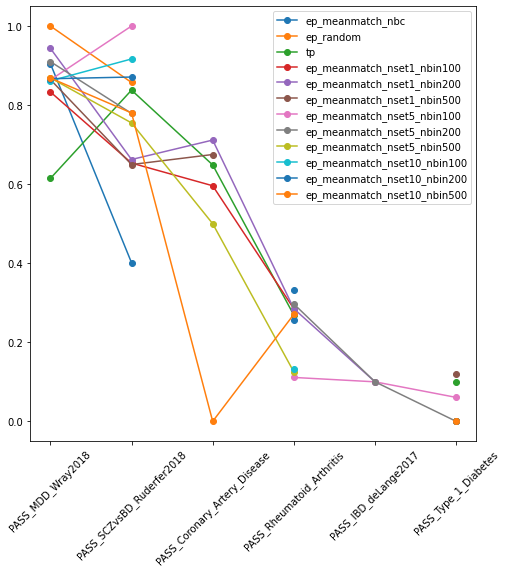

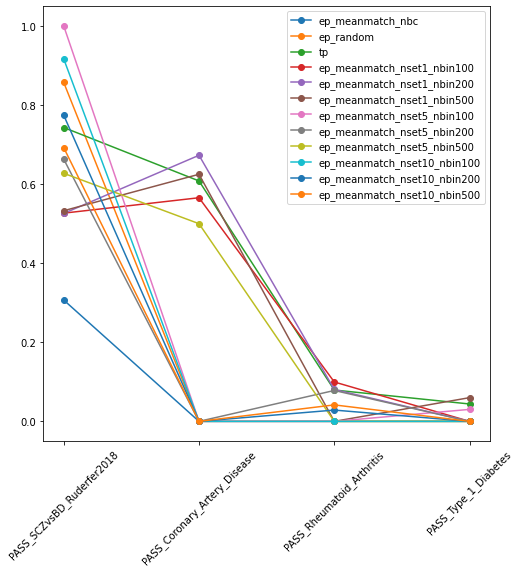

In [80]:
# for df_plot in [df_spec_tissue.copy(),df_spec_tc.copy()]:
#     df_plot = df_plot.loc[:,df_plot.sum(axis=0)>0]
#     df_plot = df_plot.T
#     df_plot['loc'] = np.arange(df_plot.shape[0])
#     plt.figure(figsize=[8,8])
#     for config in CONFIG_LIST:
#         plt.plot(df_plot['loc'], df_plot[config], label=config, marker='o')
#     plt.xticks(df_plot['loc'], df_plot.index, rotation=45)
#     plt.legend()
#     plt.show()